# Import Dataset and Libraries

In [1]:
%pip install imbalanced-learn==0.10.1
%pip install catboost==1.1.1
%pip install pycountry==22.1.10
%pip install scikit-learn==1.2.2
%pip install googletrans==4.0.0-rc1

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [39]:
import numpy as np
import pandas as pd

RANDOM_STATE = 42
TRAIN_FILE = "./train.csv"
TEST_FILE = "./submission.csv"

In [40]:
df_train = pd.read_csv(TRAIN_FILE)
df_test = pd.read_csv(TEST_FILE)
df_submission = pd.read_csv(TEST_FILE)

In [41]:
X, y = df_train.drop("is_converted", axis=1), df_train["is_converted"]
X_test = df_test.drop(["is_converted", "id"], axis=1)

# Data Preprocessing

## 1. Data Imputation

In [42]:
values = {
    **{column: 0 for column in X.columns},
    "inquiry_type": "Quotation or Purchase Consultation",
    "customer_country": "Not Found",
    "historical_existing_cnt": X["historical_existing_cnt"].mode()[0],
}

X.fillna(value=values, inplace=True)
X_test.fillna(value=values, inplace=True)

## 2. Data Cleaning 

### Feature: Customer Country

In [43]:
import pycountry


def preprocess_country(country):
    if not isinstance(country, str):
        return "Not Found"

    country = country.split("/")[-1].strip()
    country = pycountry.countries.get(name=country)
    return "Not Found" if country is None else country.alpha_3


X["customer_country"] = [
    preprocess_country(country) for country in X["customer_country"]
]

X_test["customer_country"] = [
    preprocess_country(country) for country in X_test["customer_country"]
]

### Feature: Business Unit ("business_unit")

In [44]:
X["business_unit"] = X["business_unit"].astype(
    pd.CategoricalDtype(categories=["ID", "AS", "IT", "Solution", "CM"])
)
X_test["business_unit"] = X_test["business_unit"].astype(
    pd.CategoricalDtype(categories=["ID", "AS", "IT", "Solution", "CM"])
)

In [45]:
country_frequency = X["customer_country"].value_counts(normalize=True)
X["customer_country_frequency"] = X["customer_country"].map(country_frequency)
X_test["customer_country_frequency"] = X_test["customer_country"].map(country_frequency)
country_target = (
    pd.concat([X, y], axis=1).groupby("customer_country")["is_converted"].mean()
)
X["customer_country_target"] = X["customer_country"].map(country_target)
X_test["customer_country_target"] = X_test["customer_country"].map(country_target)
owner_frequency = X["lead_owner"].value_counts(normalize=True)
X["lead_owner_frequency"] = X["lead_owner"].map(owner_frequency)
X_test["lead_owner_frequency"] = X_test["lead_owner"].map(owner_frequency)
owner_target = pd.concat([X, y], axis=1).groupby("lead_owner")["is_converted"].mean()
X["lead_owner_target"] = X["lead_owner"].map(owner_target)
X_test["lead_owner_target"] = X_test["lead_owner"].map(owner_target)
# # 각 비즈니스 유닛에 대한 가중치 - id_strategic_ver가 1/ it_strategic_ver == 0인 경우에만
weights = {
    "ID": 0.064566116,
    "AS": 0.026845638,
    "IT": 0,
    "Solution": 0.034482759,
    "CM": 0,
    #ver_win_ratio_per_bu를 보고 business_unit별로 부여
}

#map with business unit
X['business_weight'] = X.apply(lambda row: weights.get(row['business_unit'], 0) if row['id_strategic_ver'] == 1 else 0, axis=1)
X_test["business_weight"] = X_test['business_unit'].map(weights).fillna(0)

### Feature: Inquiry Type ("inquiry_type")

In [46]:
inquiry_type_remap = {
    # Quotation: Asking about the product itself.
    "Q": [
        "Quotation or Purchase Consultation",
        "Quotation or purchase consultation",
        "Quotation or Purchase consultation",
        "quotation_or_purchase_consultation",
        "Purchase or Quotation",
        "Purchase",
        "Request for quotation or purchase",
        "Sales Inquiry",
        "sales",
        "quotation_",
    ],
    # Usage: Asking about how to use the product.
    "U": [
        "Usage or Technical Consultation",
        "Usage or technical consultation",
        "usage or technical consultation",
        "usage_or_technical_consultation",
        "Technical Consultation",
        "Technical Support",
        "technical",
        "technical_consultation",
        "Request for technical consulting",
        "Product Information",
        "i want to know the details about it",
        "first Info and pricing",
        "Toi muon tim hieu thong tin ky thuat, gia ca cua sp de su dung",
        "tôi cần tham khảo giá và giải pháp từ LG",
        "Trainings",
    ],
    "O": [
        "Other",
        "Others",
        "other_",
        "other",
        "others",
        "Etc.",
        "ETC.",
        "Not specified",
        "(Select ID_Needs)",
        "IDB",
        "Services",
        "Request for Partnership",
        "Request a Demo",
        "Request for Distributorship",
        "Customer Suggestions",
        *(
            df_train["inquiry_type"]
            .value_counts()
            .loc[df_train["inquiry_type"].value_counts() < 10]
            .index.tolist()
        ),
    ],
}

for key, value in inquiry_type_remap.items():
    X.loc[X["inquiry_type"].isin(value), "inquiry_type"] = key
    X_test.loc[X_test["inquiry_type"].isin(value), "inquiry_type"] = key

### Feature: Customer Position ("customer_position")

In [47]:
X['customer_position'] = X['customer_position'].replace('decision maker', 'decision-maker')
X['customer_position'] = X['customer_position'].replace('decision influencer', 'decision-influencer')
X['customer_position'] = X['customer_position'].replace('architect/consultant', 'architecture/consult')
X['customer_position'] = X['customer_position'].replace('physics and mathematics teacher', 'math and physics teacher')
X['customer_position'] = X['customer_position'].replace('vicepresident', 'vice president')
X['customer_position'] = X['customer_position'].replace('others', 'other')

X_test['customer_position'] = X_test['customer_position'].replace('decision influencer', 'decision-influencer')
X_test['customer_position'] = X_test['customer_position'].replace('architect/consultant', 'architecture/consult')
X_test['customer_position'] = X_test['customer_position'].replace('physics and mathematics teacher', 'math and physics teacher')
X_test['customer_position'] = X_test['customer_position'].replace('vicepresident', 'vice president')
X_test['customer_position'] = X_test['customer_position'].replace('others', 'other')

In [48]:
# Classification by position and occupation
C_position_high_executive = [
    'manager', 'ceo/founder', 'c-level executive',
    'vice president', 'c-levelexecutive', 'founder',
    'commercial consultant', 'government',
    'operations', 'other - please specify - cedia association',
    'leadership/executive office/owner', 'market intelligence/research',
    'chairman', 'co-founder', 'chief executive officer',
    'ceo/fundador', 'gerente', 'president', 'genel müdür', 'bulgaria',
]

C_position_low_executive = [
    'director', 'intern', 'trainee', 'entry level',
    'employee', 'administrative', 'manufacturer',
    'system integrator', 'distributor', 'business unit director',
    'business development', 'product management', 'business partner',
    'subsidiary sales (ise)', 'business development/sales',
    'sales',
]

C_position_education = [
    'physics teacher', 'assistant professor',
    'maths lecturer', 'science teacher', 'physics faculty',
    'teacher/middle school coordinator', 'math and physics teacher',
    'professor of mathematics', 'prof.', 'professor of mathematics',
    'academic specialist', 'principal at oxford integrated pu science college'
    'assistant professor of English', 'educator', 'professor',
    'quantitative aptitude faculty', 'english trainer for ielts,toefl,pte,gre,sat exams.'
    'associate professor', 'principal & director', 'hon dean',
    'pgt physics', 'education professional', 'chemistry teacher',
    'director cum faculty at gaining apex coaching centre',
    'academic coordinator/ post graduate teacher (accountancy, business studies)/ tgt (ict)',
    'teacher', 'senior lecturer', 'neet/ olympiad expert faculty',
    'asst prof.', 'associate professor in electronics engg', 'professional trainer',
    'education',
]

C_position_hospital = [
    'hospital', 'medical device manufacturer', 'vp', 'medical imaging specialist',
    'tierarzt', 'főorvos', 'surgery professional', 'pathologist', 'radiology professional'
]

C_position_others = [
    'entry level', 'customer', 'technical',
    'exhibition', 'end-user', 'cargo', 'técnico', 'exhibitiontv',
    'proprietário(a)', 'mindenes', 'research', 'the big boss',
    'partner', 'associate/analyst', 'none', 'unpaid', 'av management',
    'engineering', 'installer', 'homeowner', 'commercial end-user'
    'lider de desarrollo', 'entrepreneurship', 'not applicable',
    'no influence',
]

C_position_consultant = [
    'consultant', 'software/solution provider', 'guest faculty',
    'career coach', 'consulting',
]


In [49]:
position_category= {
    'High Executive': C_position_high_executive,
    'Low Executive': C_position_low_executive,
    'Education': C_position_education,
    'Hospital': C_position_hospital,
    'Consultant': C_position_consultant,
    'Others': C_position_others
}

for category, positions in position_category.items():
    X.loc[X['customer_position'].isin(positions), 'C_position_1'] = category
    X_test.loc[X_test['customer_position'].isin(positions), 'C_position_1'] = category

# 'Hospital', 'Consultant', 'Education'는 무의미한 데이터로 판단 -> Others로 대체
categories_drop = ['Hospital', 'Consultant', 'Education']
X.loc[X['C_position_1'].isin(categories_drop), 'C_position_1'] = 'Others'
X_test.loc[X_test['C_position_1'].isin(categories_drop), 'C_position_1'] = 'Others'

# C_position_category one_hot_encoding
X_encoded = pd.get_dummies(X, columns=['C_position_1'])
X_test_encoded = pd.get_dummies(X_test, columns=['C_position_1'])

In [50]:
col =['C_position_1_High Executive', 'C_position_1_Low Executive', 'C_position_1_Others']

X[col] = X_encoded[col].astype(int)
X_test[col] = X_test_encoded[col].astype(int)

In [51]:
# 기존 열 drop
X.drop(['C_position_1'], axis=1, inplace=True)
X.drop(['customer_position'], axis=1, inplace=True)

X_test.drop(['C_position_1'], axis=1, inplace=True)
X_test.drop(['customer_position'], axis=1, inplace=True)

### Feature: Customer Job ("customer_job")

In [52]:
# engineer category
C_job_engineer = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and 'engineer' in job.lower().replace(" ", "").lower():
        C_job_engineer.append(job)

# tech & IT category
C_job_tech = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('tech' in job.lower().replace(" ", "").lower()
                                or 'IT' in job.lower().replace(" ", "").lower()
                                or 'software' in job.lower().replace(" ", "").lower()):
        C_job_tech.append(job)
              
# high_executive category
C_job_high_executive = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('admin' in job.lower().replace(" ", "").lower()
                                or 'entrepreneurship' in job.lower().replace(" ", "").lower()
                                or 'executive' in job.lower().replace(" ", "").lower()
                                or 'owner' in job.lower().replace(" ", "").lower() 
                                or 'manage' in job.lower().replace(" ", "").lower()
                                or 'president' in job.lower().replace(" ", "").lower()
                                or 'CEO' in job.lower().replace(" ","").lower()):
        C_job_high_executive.append(job)

# low_executive category
C_job_low_executive = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('operations' in job.lower().replace(" ", "").lower() 
                                or 'sale' in job.lower().replace(" ", "").lower()
                                or 'marketing' in job.lower().replace(" ", "").lower()
                                or 'business' in job.lower().replace(" ","").lower()):
        C_job_low_executive.append(job)  

# education category
C_job_education = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('education' in job.lower().replace(" ", "").lower() 
                                 or 'professor' in job.lower().replace(" ", "").lower()
                                 or 'educator' in job.lower().replace(" ", "").lower()
                                 or 'teach' in job.lower().replace(" ", "").lower()):
        C_job_education.append(job)

# design category
C_job_design = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('art' in job.lower().replace(" ", "").lower() 
                                 or 'design' in job.lower().replace(" ", "").lower()):
        C_job_design.append(job)

# medical category
C_job_medical = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and ('medical' in job.lower().replace(" ", "").lower() 
                                 or 'health' in job.lower().replace(" ", "").lower()
                                 or 'care' in job.lower().replace(" ", "").lower()):
        C_job_medical.append(job)
        
# NaN category
C_job_NaN = []
for job in df_train['customer_job'].unique():
    if pd.isna(job):
        C_job_NaN.append(job)

# Other category
C_job_other = []
for job in df_train['customer_job'].unique():
    if isinstance(job, str) and job not in C_job_engineer + C_job_tech + C_job_high_executive +C_job_medical + C_job_low_executive + C_job_education + C_job_design:
        C_job_other.append(job)


In [53]:
job_category = {
    'Engineer': C_job_engineer,
    'Tech & IT': C_job_tech,
    'high_executive': C_job_high_executive,
    'low_executive': C_job_low_executive,
    'Education': C_job_education,
    'Design': C_job_design,
    'Medical': C_job_medical,
    'NaN': C_job_NaN,
    'Other': C_job_other
}

for category, jobs in job_category.items():
    X.loc[df_train['customer_job'].isin(jobs), 'C_job_category'] = category
    X_test.loc[df_test['customer_job'].isin(jobs), 'C_job_category'] = category

    
# C_job_category one_hot_encoding
X_encoded = pd.get_dummies(X, columns=['C_job_category'])
X_test_encoded = pd.get_dummies(X_test, columns=['C_job_category'])

col =['C_job_category_low_executive', 'C_job_category_high_executive', 'C_job_category_Engineer', 'C_job_category_Education',
     'C_job_category_Tech & IT', 'C_job_category_Design', 'C_job_category_Medical', 'C_job_category_Other', 'C_job_category_NaN']



X[col] = X_encoded[col].astype(int)
X_test[col] = X_test_encoded[col].astype(int)


# 기존 열 drop
X.drop(['C_job_category'], axis=1, inplace=True)
X.drop(['customer_job'], axis=1, inplace=True)

X_test.drop(['C_job_category'], axis=1, inplace=True)
X_test.drop(['customer_job'], axis=1, inplace=True)

# 결측치 처리
X.loc[X['C_job_category_NaN'] == 1, 'C_job_category_Other'] = 1
X.drop(['C_job_category_NaN'], axis=1, inplace=True)
X_test.loc[X_test['C_job_category_NaN'] == 1, 'C_job_category_Other'] = 1
X_test.drop(['C_job_category_NaN'], axis=1, inplace=True)

### Feature: Response Corporate ("corporate_category")

In [54]:
def label_encoding(series: pd.Series) -> pd.Series:
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

def categorize(num):
    if num > 4000:
        return 'converted_high'
    elif num > 288:
        return 'converted_middle'
    else:
        return 'converted_low'

In [55]:
converted_counts = X.groupby('response_corporate').size().to_dict()
X['response_corporate_num'] = X['response_corporate'].map(converted_counts).fillna(0).astype(int)
X['corporate_converted_category'] = X['response_corporate_num'].apply(categorize)

converted_counts = X_test.groupby('response_corporate').size().to_dict()
X_test['response_corporate_num'] = X_test['response_corporate'].map(converted_counts).fillna(0).astype(int)
X_test['corporate_converted_category'] = X_test['response_corporate_num'].apply(categorize)


In [56]:
X['corporate_category'] = label_encoding(X["corporate_converted_category"])
X_test['corporate_category'] = label_encoding(X_test["corporate_converted_category"])

In [57]:
del X['corporate_converted_category']
del X_test['corporate_converted_category']

### Feature: Product Category ("product_category")

In [58]:
def preprocess_product_dict(df: pd.DataFrame) -> dict:
    product_category_remap = {
        # IS: Integrated Solutions Inquiry - INTEGRATED SOLUTIONS
        "IS" : [
            "monitor signage",
            "commercial tv",
            "monitor",
            "monitor tv",
            "pc",
            "projector",
            "robot",
            "system ac",
            "ems",
            "rac",
            "tv",
            "refrigerator",
            "washing machine",
            "aircare",
            "vaccum cleaner",
            "styler",
            "dryer",
            "built-in/cooking",
            "home beauty",
            "water care",
            "audio/video",
            "lg thinq home",
            "smart home",
            "lg one:quick_flex",    # healthcare solutions
            "one:quick",    # healthcare solutions
            "quick",    # healthcare solutions
            "services",
        ],
        # CD: B2B Product Inquiry - Commercial Display
        "CD": [
            "^(?=.*\d)[A-Za-z0-9.\s-]+$",    # tv panel model name filter
            "medical display",
            "led bloc",
            "uhd signage",
            "commercial display",
            "oled signage",
            "led signage",
            "video wall signage",
            "interactive signage",
            "high brightness signage",
            "special signage",
            "standard signage",
            "hotel tv",
            "hospital tv",
            "accessories",
            "software solution",
            "signage care solution",
            "webos",
            "pro:centric",
            "one:quick series",
            "signage",
            "display",
            'led',
            'wall',    # video wall,
            'MAGNIT',
            "centric",
            "all",
            "idb",
            "virtual",
            "virtual production",
            "createboard",
        ],
        # IT: B2B Product Inquiry - IT PRODUCTS
        "IT": [
            "monitor",
            "laptop",
            "projector",
            "cloud device",
        ],
        # HE: B2B Product Inquiry - HVAC/ESS
        "HE": [
            "control",
            "ventilation",
            "vrf",
            "split",
            "multi-split",
            "single-split",
            "chiller",
            "heating",
            "energy storage system",
            "ess",
            "solar",
            "heat",
            "water",
            "air condition",
            "air",
            "ceiling",
            "cassette",
            "ondition",
            "cool",
            "multi",
            "support",
        ],
        # CM: B2B Product Inquiry - Compressor and Motor
        "CM": [
            "reciprocating compressor",
            "rotary compressor",
            "scroll compressor",
            "compressor",
            "motor",
        ],
        # RB: B2B Product Inquiry - Robot
        "RB": [
            "LG CLOi UV-C Bot",
            "LG CLOi ServeBot",
            "Shelf type",
            "Drawer type",
            "LG CLOi GuideBot",
            "CLOi",
            "UV-C",
            "Bot",
        ],
        # AM: B2B Product Inquiry - ADVANCED MATERIALS
        "AM": [
            "Antimicrobial",
            "Porcelain enamel",
            "Porcelain",
            "enamel",
            "Specialty glass",
            "Specialty",
            "glass",
        ],
        # others
        "others": [
            "[\(\)]",
            "MISSING_VALUE",    # missing value
            "commercial laundry"    # B2B Product Inquiry
            "others",
            "ohters",
            "other",
            "ohter",
            'otros',
            'outros',
            'error',
            "etc",
        ]
    }
    
    return product_category_remap

In [59]:
from googletrans import Translator


def translate_sentence(sentence: str, dest: str = "en") -> str:
    translator = Translator()
    return translator.translate(sentence, src="auto", dest=dest).text


def detect_language(sentence: str) -> str:
    translator = Translator()
    return translator.detect(sentence).lang


def apply_translation(text):
    global already
    if text in already: return already[text]
    
    lang = detect_language(text)
    tran = translate_sentence(text)
    already[text] = tran

    return tran

In [60]:
from tqdm import tqdm
tqdm.pandas()

def preprocess_product_category(df: pd.DataFrame) -> pd.DataFrame:
    # making dictionary depending on LG official website
    product_category_remap = preprocess_product_dict(df)
    
    # filling missing value: "0"
    df_pc = df['product_category'].fillna("MISSING_VALUE", inplace=False)

    # preprocessing by category
    for key, value in product_category_remap.items():
        regex = '|'.join(value)
        
        df_pc.loc[df_pc.str.contains(
            regex,         # chekcing string pattern
            na=False,     # missing value return is boolean
            case=False    # ignore upper and lower
        )] = key
        
    # 'product_category' 열에서 product_category_remap에 없는 값을 필터링
    filtered_categories = df_pc[~df_pc.isin(product_category_remap)]    
    # tqdm을 사용하여 진행 상태를 표시하면서 apply_translation 함수 적용
    filtered_categories = filtered_categories.progress_apply(apply_translation)
    # 기존 df에 번역한 값을 저장
    df_pc.loc[filtered_categories.index] = filtered_categories
    
    # 20개보다 적게 있는 자잘한 값들을 전부 etc에 추가
    etc = (
        df_pc
        .value_counts()
        .loc[df_pc.value_counts() < 20]
        .index.tolist()
    )
    product_category_remap['others'].extend(etc)
        
    # preprocessing by category
    for key, value in product_category_remap.items():
        regex = '|'.join(value)
        
        df_pc.loc[df_pc.str.contains(
            regex,         # chekcing string pattern
            na=False,     # missing value return is boolean
            case=False    # ignore upper and lower
        )] = key 
  
    return df_pc

In [61]:
# translator가 오래 걸려, 저장용 dictionary 선언
already = dict()
df_pc = preprocess_product_category(df_train)
X['product_category'] = df_pc

# translator가 오래 걸려, 저장용 dictionary 선언
already = dict()
df_pc = preprocess_product_category(df_test)
X_test['product_category'] = df_pc

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.21s/it]


## 3. Feature Engineering

In [62]:
country_frequency = X["customer_country"].value_counts(normalize=True)
X["customer_country_frequency"] = X["customer_country"].map(country_frequency)
X_test["customer_country_frequency"] = X_test["customer_country"].map(country_frequency)

country_target = (
    pd.concat([X, y], axis=1).groupby("customer_country")["is_converted"].mean()
)
X["customer_country_target"] = X["customer_country"].map(country_target)
X_test["customer_country_target"] = X_test["customer_country"].map(country_target)

owner_frequency = X["lead_owner"].value_counts(normalize=True)
X["lead_owner_frequency"] = X["lead_owner"].map(owner_frequency)
X_test["lead_owner_frequency"] = X_test["lead_owner"].map(owner_frequency)

owner_target = pd.concat([X, y], axis=1).groupby("lead_owner")["is_converted"].mean()
X["lead_owner_target"] = X["lead_owner"].map(owner_target)
X_test["lead_owner_target"] = X_test["lead_owner"].map(owner_target)


## 4. Feature Encoding

In [63]:
def encode_features(
    df: pd.DataFrame,
    features=["enterprise", "business_unit", "inquiry_type", "bant_submit"],
) -> pd.DataFrame:
    df_encoded = pd.get_dummies(df[features], columns=features)
    df_encoded = df_encoded.apply(lambda x: x.astype("category").cat.codes)
    df = pd.concat([df, df_encoded], axis=1).drop(features, axis=1)
    return df


X = encode_features(X)
X_test = encode_features(X_test)

## 5. Feature Normalization

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

standard_transformer = Pipeline(steps=[("standardize", StandardScaler())])
column_transformer = ColumnTransformer(
    transformers=[
        ("std", standard_transformer, ["lead_desc_length", "historical_existing_cnt"]),
    ],
    verbose_feature_names_out=False,
    remainder="passthrough",
)
column_transformer.set_output(transform="pandas")

X = column_transformer.fit_transform(X)
X_test = column_transformer.transform(X_test)

## 6. Outlier Removal

## 7. Feature Removal

In [65]:
features_to_drop = [
    "customer_country",
    "business_subarea",
    "business_area",
    "customer_idx",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_type",
    "expected_timeline",
    "lead_owner",
    "response_corporate",
    "response_corporate_num",
    "id_strategic_ver",
    "it_strategic_ver",
    "idit_strategic_ver"
]

X = X.drop(features_to_drop, axis=1)  # type: ignore
X_test = X_test.drop(features_to_drop, axis=1)  # type: ignore

In [66]:
X.columns.tolist()

['lead_desc_length',
 'historical_existing_cnt',
 'com_reg_ver_win_rate',
 'ver_cus',
 'ver_pro',
 'ver_win_rate_x',
 'ver_win_ratio_per_bu',
 'customer_country_frequency',
 'customer_country_target',
 'lead_owner_frequency',
 'lead_owner_target',
 'business_weight',
 'C_position_1_High Executive',
 'C_position_1_Low Executive',
 'C_position_1_Others',
 'C_job_category_low_executive',
 'C_job_category_high_executive',
 'C_job_category_Engineer',
 'C_job_category_Education',
 'C_job_category_Tech & IT',
 'C_job_category_Design',
 'C_job_category_Medical',
 'C_job_category_Other',
 'corporate_category',
 'enterprise_Enterprise',
 'enterprise_SMB',
 'business_unit_ID',
 'business_unit_AS',
 'business_unit_IT',
 'business_unit_Solution',
 'business_unit_CM',
 'inquiry_type_O',
 'inquiry_type_Q',
 'inquiry_type_U',
 'bant_submit_0.0',
 'bant_submit_0.25',
 'bant_submit_0.5',
 'bant_submit_0.75',
 'bant_submit_1.0']

# Modeling

In [67]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)

# K-Fold Cross Validation

In [68]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score, roc_auc_score)
from sklearn.model_selection import StratifiedKFold

kfolds, scores = (
    StratifiedKFold(n_splits=5, random_state=RANDOM_STATE, shuffle=True),
    [],
)

for fold_idx, (train_idx, val_idx) in enumerate(kfolds.split(X, y)):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_val, y_val = X.iloc[val_idx], y.iloc[val_idx]

    sm = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
    X_train, y_train = sm.fit_resample(X_train, y_train)  # type: ignore

    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    prediction = np.where(prediction == "True", True, False)

    print(f"Accuracy (Fold {fold_idx}): {accuracy_score(y_val, prediction)}")
    print(f"Precision (Fold {fold_idx}): {precision_score(y_val, prediction)}")
    print(f"Recall (Fold {fold_idx}): {recall_score(y_val, prediction)}")
    print(f"F1-Score (Fold {fold_idx}): {f1_score(y_val, prediction)}")
    print(
        f"ROC-AUC Score (Fold {fold_idx}): "
        + f"{roc_auc_score(y_val, model.predict_proba(X_val)[:,1])}\n"
    )

    scores.append(f1_score(y_val, prediction))

print(f"Cross-Validation Average F1-Score: {np.mean(scores)}")

Accuracy (Fold 0): 0.9403035413153457
Precision (Fold 0): 0.6066775244299675
Recall (Fold 0): 0.7680412371134021
F1-Score (Fold 0): 0.6778889899909009
ROC-AUC Score (Fold 0): 0.9664975433813296

Accuracy (Fold 1): 0.9430860033726813
Precision (Fold 1): 0.6228143213988343
Recall (Fold 1): 0.7711340206185567
F1-Score (Fold 1): 0.6890833717181023
ROC-AUC Score (Fold 1): 0.9707388316151202

Accuracy (Fold 2): 0.9389544688026982
Precision (Fold 2): 0.5963949843260188
Recall (Fold 2): 0.7845360824742268
F1-Score (Fold 2): 0.6776491540516473
ROC-AUC Score (Fold 2): 0.9663414368615868

Accuracy (Fold 3): 0.9414839797639123
Precision (Fold 3): 0.612012987012987
Recall (Fold 3): 0.777319587628866
F1-Score (Fold 3): 0.6848319709355132
ROC-AUC Score (Fold 3): 0.9682436833186601

Accuracy (Fold 4): 0.9424066110127329
Precision (Fold 4): 0.6206896551724138
Recall (Fold 4): 0.7608247422680412
F1-Score (Fold 4): 0.6836498378879111
ROC-AUC Score (Fold 4): 0.964502718623637

Cross-Validation Average F1-

# Create Submission

In [69]:
sm = SMOTE(sampling_strategy="minority", random_state=RANDOM_STATE)
X, y = sm.fit_resample(X, y)  # type: ignore
model.fit(X, y)

prediction = model.predict(X_test)
prediction = np.where(prediction == "True", True, False)

df_submission["is_converted"] = prediction
df_submission.to_csv("submission.csv", index=False)
df_submission.head()

,id,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,19844,0.00,/ / Brazil,ID,0.073248,47466,End Customer,Enterprise,53.0,NaN,...,LGESP,NaN,1,0,0.001183,0.049840,retail,Electronics & Telco,278,True
1,9738,0.25,400 N State Of Franklin Rd Cloud IT / Johnson...,IT,NaN,5405,End Customer,SMB,NaN,NaN,...,LGEUS,NaN,0,0,0.000013,NaN,transportation,Others,437,True
2,8491,1.00,/ / U.A.E,ID,NaN,13597,Specifier/ Influencer,SMB,NaN,NaN,...,LGEGF,less than 3 months,0,0,0.000060,0.131148,hospital & health care,General Hospital,874,False
3,19895,0.50,/ Madison / United States,ID,0.118644,17204,NaN,Enterprise,NaN,NaN,...,LGEUS,more than a year,0,0,0.001183,0.049840,retail,NaN,194,False
4,10465,1.00,/ Sao Paulo / Brazil,ID,0.074949,2329,End Customer,Enterprise,2.0,1.0,...,LGESP,less than 3 months,1,1,0.003079,0.064566,corporate / office,Engineering,167,True


In [70]:
model.feature_importances_

array([8.15621833e+00, 6.30171557e+00, 1.19353306e+00, 4.84812866e-01,
       1.87424666e-01, 8.15829083e+00, 3.75254870e+00, 1.49591578e+01,
       9.39477089e+00, 8.68768357e+00, 2.42339051e+01, 1.54908654e+00,
       2.73053901e-01, 3.73697774e-01, 5.43034215e-01, 4.73425640e-01,
       5.07657673e-01, 5.89550148e-01, 1.09853968e-01, 1.92232542e-01,
       2.49149199e-01, 1.28932014e-01, 1.19459720e+00, 4.29903076e-01,
       7.03286183e-01, 2.59307945e-01, 6.94604800e-01, 8.73399406e-01,
       4.74562869e-01, 4.90808462e-03, 1.85680831e-05, 3.52102283e-01,
       4.89541741e-01, 6.63661647e-01, 9.37600517e-02, 1.30965039e+00,
       1.30748401e+00, 2.42686227e-01, 4.06790595e-01])

In [71]:
feature_names = X.columns.tolist()

<AxesSubplot:>

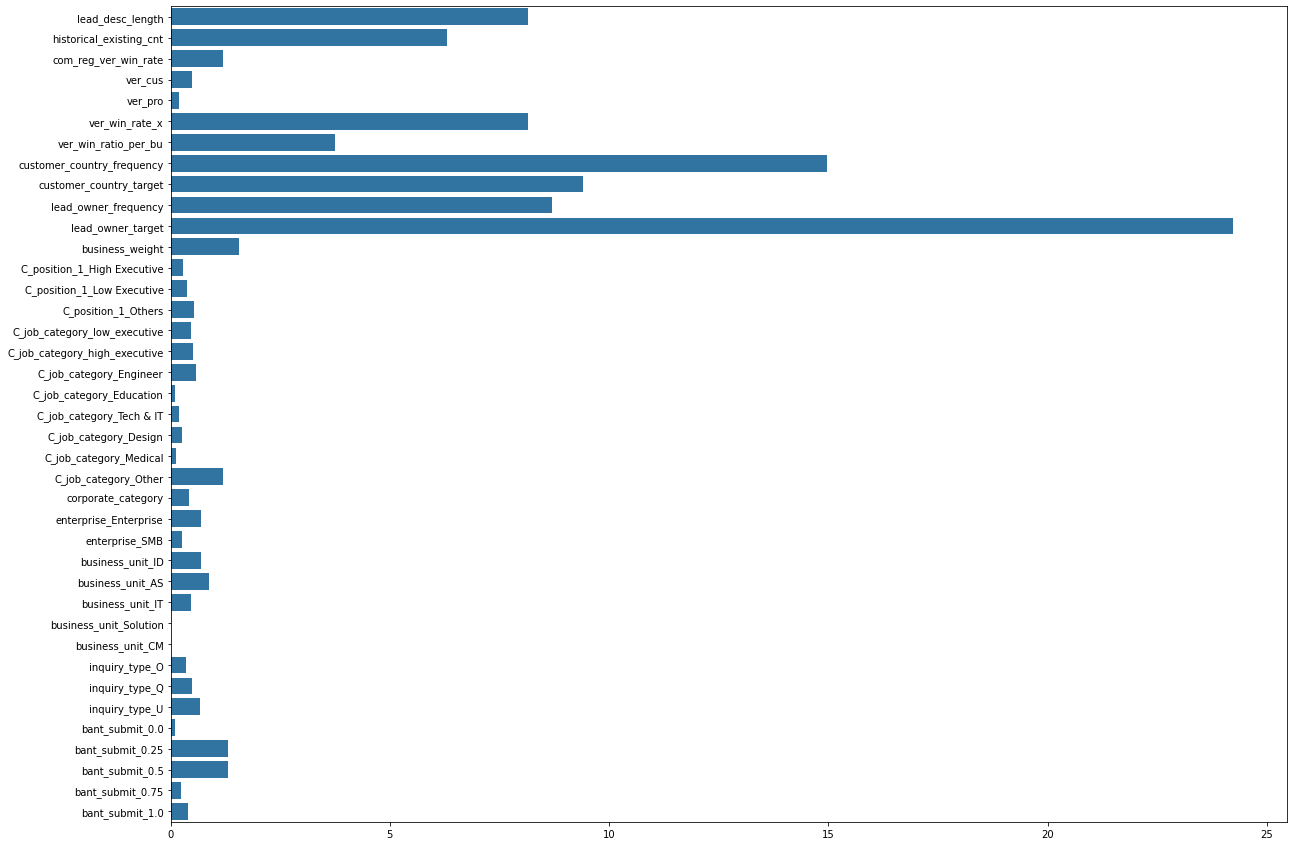

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
sns.barplot(x=model.feature_importances_, y=feature_names)